In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import idx2numpy
import numpy as np
import struct
import matplotlib.pyplot as plt
from array import array
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


In [42]:
import numpy as np
import struct
from array import array

class MnistDataloader(object):
    def __init__(self, training_images_filepath, training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train), (x_test, y_test) 

# path for MINST data
training_images_filepath = "train-images-idx3-ubyte"
training_labels_filepath = "train-labels-idx1-ubyte"
test_images_filepath = "t10k-images-idx3-ubyte"
test_labels_filepath = "t10k-labels-idx1-ubyte"

# Create an instance of MnistDataloader
mnist_loader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist_loader.load_data()

# Convert data to PyTorch tensors
x_train = torch.FloatTensor(x_train).unsqueeze(1) / 255.0
y_train = torch.LongTensor(y_train)
x_test = torch.FloatTensor(x_test).unsqueeze(1) / 255.0
y_test = torch.LongTensor(y_test)

# Define DataLoader objects for training and testing sets
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=64, shuffle=True)
test_loader = DataLoader(list(zip(x_test, y_test)), batch_size=64, shuffle=False)


In [43]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Max pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # 10 output classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
# Create an instance of the CNN model
model = CNN()

# Print the model architecture
print(model)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [44]:
# Number of parameters
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)

# Number of multiplication operations for each layer
conv_ops = 3 * 3 * 16 * 28 * 28  
fc1_ops = 16 * 14 * 14 * 128    
fc2_ops = 128 * 10               
total_ops = conv_ops + fc1_ops + fc2_ops
print("Total multiplication operations:", total_ops)
# Convolutional Layer 1:
conv1_input_size = (1, 28, 28)
conv1_output_channels = 16
conv1_output_size = (conv1_output_channels, 28, 28)

# Fully Connected Layer 1:
fc1_input_size = conv1_output_channels * 14 * 14
fc1_output_size = 128

# Fully Connected Layer 2 (Output Layer):
fc2_input_size = 128
fc2_output_size = 10

print("Convolutional Layer 1:")
print("  Input size:", conv1_input_size)
print("  Output size:", conv1_output_size)
print("Fully Connected Layer 1:")
print("  Input size:", fc1_input_size)
print("  Output size:", fc1_output_size)
print("Fully Connected Layer 2 (Output Layer):")
print("  Input size:", fc2_input_size)
print("  Output size:", fc2_output_size)


Total parameters: 206922
Total multiplication operations: 515584
Convolutional Layer 1:
  Input size: (1, 28, 28)
  Output size: (16, 28, 28)
Fully Connected Layer 1:
  Input size: 3136
  Output size: 128
Fully Connected Layer 2 (Output Layer):
  Input size: 128
  Output size: 10


In [45]:
# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()  
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):  
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:  
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 1000:.3f}")
            running_loss = 0.0

print("Finished Training")

# Evaluation on the test set
model.eval()  
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:  
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")

Finished Training
Accuracy on test set: 99.04%


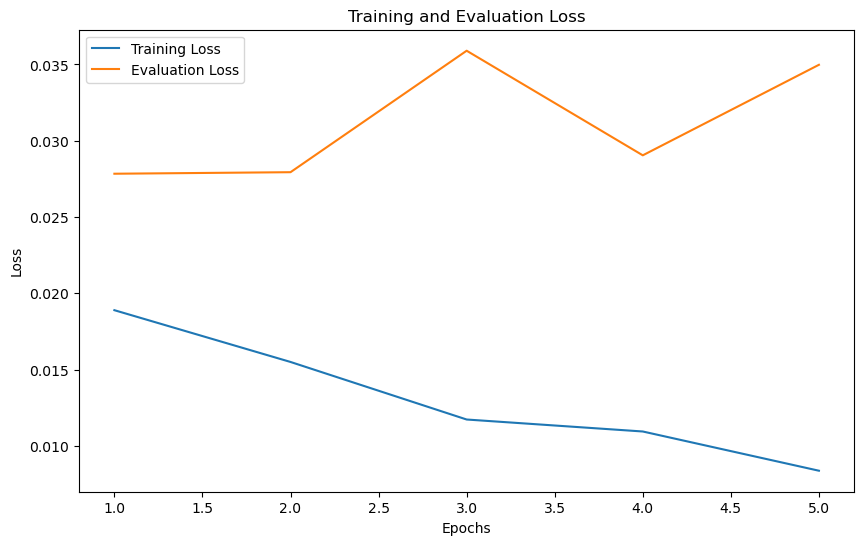

In [46]:
# Create a SummaryWriter for TensorBoard
writer = SummaryWriter()

# Training loop
epochs = 5
train_losses = []
eval_losses = []
total_iterations = len(train_loader) * epochs
for epoch in range(epochs):
    model.train() 
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):  
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Record training loss
        writer.add_scalar('Training Loss', loss.item(), epoch * len(train_loader) + i + 1)

        # Print every 1000 mini-batches
        if i % 1000 == 999:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 1000:.3f}")
            running_loss = 0.0

    # Evaluation on the test set
    model.eval()  
    eval_loss = 0.0
    with torch.no_grad():
        for data in test_loader:  
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()

    # Record evaluation loss
    writer.add_scalar('Evaluation Loss', eval_loss / len(test_loader), epoch + 1)
    
    # Append losses for plotting
    train_losses.append(running_loss / len(train_loader))
    eval_losses.append(eval_loss / len(test_loader))

# Close the SummaryWriter
writer.close()


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), eval_losses, label='Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss')
plt.legend()
plt.show()
